# Lab 2: Recommender systems

Following the second lecture of this week, we will now zoom in a bit more into recommender systems.

More specifically, we are going to try out matrix factorization on a slice of the first Movielens dataset.

While doing this, you also will be introduced to a few handy data handling routines in Python.

## About the Movielens data
Movielens (https://movielens.org/) is a movie recommendation service run by the Grouplens (http://grouplens.org/) team at the University of Minnesota. Over the years, the service has been growing considerably, and once every few years, Grouplens releases new anonymized usage data to the community (http://grouplens.org/datasets/movielens/), which have become de facto benchmarking standards in the Recommender Systems research community.

In 1998, the first released dataset consisted of 100,000 ratings (1000 users, 1700 movies). The most recently released benchmark dataset (2014) consisted of 20 million ratings (138,000 users, 27,000 movies).

In the current lab session, we will not focus on the big data crunching, but rather on getting a better practical feeling on how to handle user-item data, as well as the implications of Matrix Factorization.

## What to hand in
As final deliverable to demonstrate your successful completion of this assignment, please go to https://www.dropbox.com/request/UR4fXWKPsDRdjKNKhVZY and submit a file named [studentNumberMember1_studentNumberMember2.pdf].

This file should:
* Include **three** latent factor scatter plots, obtained for **three different input data slices** (which should differ at least in terms of user population size).
* For each of the scatter plots, please:
  * specify the characteristics of your input data (e.g. population size, selection criteria for users and films);
  * based on the plot, give a possible interpretation of what the factors represented by the x and y axes of your plot may indicate.

Further instructions can be found further down this notebook, at the point where we give an example plot.

## Importing the data
We have prepared a subset of the Movielens 100k dataset, which should automagically be downloaded to your (virtual) machine:

In [48]:
from datasets import CS4065_Dataset
movielens_paths = CS4065_Dataset.get_movielens_subset()

<code>movielens_paths</code> is a dictionary, keyed by three file names in the Movielens 100k dataset:
* <code>u.data</code>, containing tab-separated rating data (specifying user ID, movie ID, rating, timestamp);
* <code>u.user</code>, containing pipe-separated anonymized demographics data for all users in the dataset (specifying user ID, age, gender, occupation, ZIP code);
* <code>u.item</code>, containing pipe-separated movie background information (specifying movie ID, title, genres, IMDB URLs, and more).

In [49]:
# Verify the contents of movielens_paths
print movielens_paths

{'u.item': '/home/student/data/cs4065/movielens_subset/u.item', 'u.user': '/home/student/data/cs4065/movielens_subset/u.user', 'u.data': '/home/student/data/cs4065/movielens_subset/u.data'}


## Selecting analysis data

In this lab, we will primarily use data from <code>u.item</code>. The information in <code>u.user</code> is interesting though for assessing potential characterizing user features, and the information in <code>u.item</code> was used by us to manually select a small set of movie IDs, for which we expect that the fan base will show some variation.

We put our selection in a <code>movie_data</code> dictionary:

In [50]:
# Initialization of the dictionary.
# It will be keyed by movie ID, and have the IMDB movie title as corresponding value.
movie_data = {}

# We now populate the dictionary with some manually chosen examples,
# for which we expect to see some different underlying fan bases.

# First, we add three animated movies about princesses.
movie_data[418] = 'Cinderella (1950)'
movie_data[538] = 'Anastasia (1997)'
movie_data[542] = 'Pocahontas (1995)'
# Then, we add three psychological horror movies.
movie_data[200] = 'Shining, The (1980)'
movie_data[98] = 'Silence of the Lambs, The (1991)'
movie_data[185] = 'Psycho (1960)'
# Subsequently, we add three musical movies.
movie_data[186] = 'Blues Brothers, The (1980)'
movie_data[451] = 'Grease (1978)'
movie_data[289] = 'Evita (1996)'
# And finally, we add three movies taking place in space.
movie_data[50] = 'Star Wars (1977)'
movie_data[89] = 'Blade Runner (1982)'
movie_data[135] = '2001: A Space Odyssey (1968)'


movie_data[127] ='Godfather, The (1972)'
movie_data[423] = 'E.T. the Extra-Terrestrial (1982)'
movie_data[485] = 'My Fair Lady (1964)'

# Now, we have a dictionary with 12 items:
print movie_data
print '\nMovie %d is titled "%s".' % (200, movie_data[200])

{289: 'Evita (1996)', 418: 'Cinderella (1950)', 451: 'Grease (1978)', 485: 'My Fair Lady (1964)', 135: '2001: A Space Odyssey (1968)', 200: 'Shining, The (1980)', 423: 'E.T. the Extra-Terrestrial (1982)', 98: 'Silence of the Lambs, The (1991)', 50: 'Star Wars (1977)', 89: 'Blade Runner (1982)', 185: 'Psycho (1960)', 538: 'Anastasia (1997)', 186: 'Blues Brothers, The (1980)', 542: 'Pocahontas (1995)', 127: 'Godfather, The (1972)'}

Movie 200 is titled "Shining, The (1980)".


## Extracting the rating data

Next step: we won't look at 100,000 ratings, but **only at ratings for any of these movies**.

Let's first put the IDs of the movies we are interested in in a separate variable.

In [51]:
movies_considered = movie_data.keys()
# For convenience, we will sort the movies by ID.
movies_considered = sorted(movies_considered)
# How many movies will we consider again?
len(movies_considered)

15

For extracting the rating data, we will use the <code>pandas</code> module. It offers some more advanced data structures and corresponding handling capabilities than simple Python dictionaries would be capable of.

We will illustrate some of the possibilities here, but see http://pandas.pydata.org/ and the documentation at http://pandas.pydata.org/pandas-docs/version/0.17.1/ for more extensive background and more advanced examples.

In [52]:
import pandas

A first neat feature is that we can use the <code>read_csv</code> function to read formatted data into a so-called DataFrame:

In [53]:
# let's check the help documentation for read_csv
help(pandas.read_csv)

Help on function read_csv in module pandas.io.parsers:

read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=None, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal='.', lineterminator=None, quotechar='"', quoting=0, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=False, error_bad_lines=True, warn_bad_lines=True, skip_footer=0, doublequote=True, delim_whitespace=False, as_recarray=False, compact_ints=False, use_unsigned=False, low_memory=True, buffer_lines=None, memory_map=False, float_precision=

Clearly, there are many options.
What we want to do in the current case, is reading in the <code>u.data</code> file, and giving it proper headers:

In [54]:
all_rating_data = pandas.read_csv(
    movielens_paths['u.data'], # path to file to be read
    sep = '\t', # the data we are reading is tab-separated
    names = ['user_id', 'movie_id', 'rating', 'timestamp'] # custom indicated names for the columns to be read
)

In the way they are printed, dataframes may somewhat remind you of database tables:

In [55]:
all_rating_data.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Some further possibilities:

In [56]:
# return the data at row 3
print all_rating_data.loc[3]

user_id            244
movie_id            51
rating               2
timestamp    880606923
Name: 3, dtype: int64


In [57]:
# return the rating of the data at row 3
print all_rating_data.loc[3]['rating']

2


In [58]:
# find all rows corresponding to ratings for Cinderella (movie ID 418)
cinderella_ratings = all_rating_data.loc[all_rating_data['movie_id'] == 418]

## Question
How many people rated Cinderella?

In [59]:
# enter your code here
print cinderella_ratings
print len(cinderella_ratings)

       user_id  movie_id  rating  timestamp
984         13       418       2  882398763
1010       275       418       3  875154718
1074       291       418       4  875086920
1198       303       418       4  879483510
1408        59       418       2  888205188
2384       254       418       3  886473078
2702       128       418       4  879968164
4732       130       418       5  875801631
5092       298       418       4  884183406
5407       290       418       3  880474293
5848       279       418       3  875733888
6104       102       418       3  883748450
7006        49       418       3  888067031
7040       299       418       4  889501790
7056       233       418       4  877664010
9277       340       418       5  884990669
9469       311       418       4  884365202
9881        16       418       5  877724727
10522      276       418       4  874792870
10630       42       418       5  881108147
11002       10       418       4  877886783
11877      225       418       5

## Question
Using the <code>cinderella_ratings</code> variable, extract and print the ratings of people who hated Cinderella (that is, who gave the movie a rating of 1).

In [60]:
# replace 'None' below by your code to do the proper extraction
cinderella_hate_ratings = cinderella_ratings[cinderella_ratings['rating']==1]

# add your printing statement here
print cinderella_hate_ratings

       user_id  movie_id  rating  timestamp
58689      608       418       1  880405971
90549      524       418       1  884637598
95254      865       418       1  880235099


We might as well check the demographics characteristics of the people who gave Cinderella such a low score.

Demographics info is available in the file at location <code>movielens_paths['u.user']</code>.
As we stated before, this info is pipe-separated, a sample line is:

<code>14|45|M|scientist|55106</code>.

The values indicated correspond to the elements

<code>user_ID|age|gender|occupation|ZIP_code</code>.

## Question
Read the user demographics data into a variable <code>user_data</code>.

In [61]:
# user_data = None # replace None by your code
user_data = pandas.read_csv(
    movielens_paths['u.user'], # path to file to be read
    sep = '|', # the data we are reading is tab-separated
    names = ['user_id', 'age', 'gender', 'occupation','ZIP_code'] # custom indicated names for the columns to be read
)

# Uncomment the following line to display the demographics information of the Cinderella haters.
user_data.loc[user_data['user_id'].isin(cinderella_hate_ratings['user_id'])]

,user_id,age,gender,occupation,ZIP_code
523,524,56,M,educator,02159
607,608,22,M,other,10003
864,865,25,M,artist,11231


## Selecting data of interest
We only want to keep ratings for the movies we are interested in. For this, we can make use of membership testing on our <code>movies_considered</code> variable:

In [62]:
ratings_for_movies = all_rating_data.loc[all_rating_data['movie_id'].isin(movies_considered)]

In [63]:
# how many ratings do we have for our considered movies?
len(ratings_for_movies)

3716

pandas offers <code>unique()</code> and <code>nunique()</code> functions which are similar to <code>DISTINCT</code> and <code>COUNT(DISTINCT)</code> in SQL:

In [64]:
# how many unique users gave the ratings for our movies of interest?
print ratings_for_movies['user_id'].nunique()

804


## Question
What is the sparsity proportion of the user-item matrix of the <code>ratings_for_movies</code> data?

That is, what is the ratio of zero-valued (so unrated) items over the total number of elements in the user-item matrix?

In [65]:
# replace the code below by your code to compute the sparsity proportion
empty_element_for_matrix_= ratings_for_movies['user_id'].nunique()*len(movies_considered)
print (empty_element_for_matrix_-len(ratings_for_movies))*1.0/empty_element_for_matrix_

0.691873963516


## Starting small: focusing on actively rating users
As a first small example, let's first focus on a small set of users.

Let's say we want to select the 10 users who rated most of the movies of our interest.

Using <code>groupby</code> and <code>unique()</code>, we can flatten our rating table to collect a single list of rated movies per unique user ID:

In [66]:
users_to_rated_movies = ratings_for_movies.groupby('user_id')['movie_id'].unique()
# which movie IDs were rated by user 1?
print users_to_rated_movies
users_to_rated_movies[1]

user_id
1                  [98, 186, 185, 200, 135, 89, 50, 127]
2                                         [50, 127, 289]
4                                                   [50]
5        [98, 423, 418, 185, 89, 451, 135, 186, 50, 200]
6      [98, 135, 423, 200, 50, 485, 186, 538, 185, 89...
7      [200, 451, 127, 485, 89, 423, 185, 542, 418, 1...
8                                          [50, 89, 127]
9                                                   [50]
10           [289, 200, 135, 418, 186, 127, 98, 50, 185]
11                              [135, 185, 423, 98, 451]
12                                    [200, 50, 98, 127]
13     [98, 186, 418, 451, 289, 423, 185, 89, 538, 20...
14                                    [98, 50, 127, 186]
15                                        [127, 289, 50]
16                     [89, 418, 200, 98, 423, 135, 127]
18     [89, 185, 186, 423, 485, 451, 135, 200, 98, 41...
20                                    [186, 98, 423, 50]
21                     

array([ 98, 186, 185, 200, 135,  89,  50, 127])

But we can also directly call <code>nunique()</code> to find the number of rated movies per user:

In [67]:
users_to_rating_count = ratings_for_movies.groupby('user_id')['movie_id'].nunique()
# how many movies were rated by user 1?
users_to_rating_count[1]

8

To identify the most active users, we sort the user IDs based on the amount of movies they rated, in descending order.

In [68]:
users_sorted_by_rating_count = users_to_rating_count.sort_values(ascending = False)
print users_sorted_by_rating_count.head()

user_id
13     14
846    13
313    13
7      13
234    13
Name: movie_id, dtype: int64


We now select the 10 most active users.

In [69]:
user_num_considered_index=len(users_sorted_by_rating_count)
print len(users_sorted_by_rating_count)
users_considered = users_sorted_by_rating_count[0:user_num_considered_index].keys()
# again, for convenience we sort our table
users_considered = sorted(users_considered)

print users_considered

# is user 1 among the most active users?
print 1 in users_considered
# is user 13 among the most active users?
print 13 in users_considered

804
[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130, 131, 132, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 148, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 162, 163, 165, 169, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 192, 193, 194, 195, 197, 198, 200, 201, 202, 203, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259, 260, 262, 263, 26

In [70]:
# If you want to see the demographics of the selected users, uncomment the following line.
user_data.loc[user_data['user_id'].isin(users_considered)]

,user_id,age,gender,occupation,ZIP_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703
10,11,39,F,other,30329


## Preparing the matrix factorization
We now know what movies we are interested in, and what users we are interested in. Now all we need to do is establishing a user-item matrix, and applying factorization on it.

We use numpy for handling matrices.

In [71]:
import numpy as np

## Question
What are the dimensions of the user-item matrix, which we will call $\mathbf{R}$ (as it holds ratings)?

Enter the appropriate number of rows and columns below, so we can initialize an all-zero matrix with the proper size.

In [72]:
num_rows = len(users_considered) # Replace 1000 by the desired number of rows
num_columns = len(movies_considered) # Replace 1000 by the desired number of columns

R = np.zeros((num_rows, num_columns))
# print R

There is one more thing to resolve. Our user IDs and movie IDs are numbers, but they do not reflect the desired coordinates in a user-item matrix.

That is, R[0,0] should reflect the rating of 'the first user' on 'the first movie'.

In [73]:
# What is the lowest user ID we have?
print users_considered[0]
# What is the lowest movie ID we have?
print movies_considered[0]
print 'So, R[0,0] should reflect the rating of user %d on movie %d.' % (users_considered[0], movies_considered[0])

1
50
So, R[0,0] should reflect the rating of user 1 on movie 50.


We therefore will create lookup maps, which map user and movie IDs to a matrix row/column index [0, 1, 2...], and the other way around.

In [74]:
user_to_index = dict(zip(users_considered, range(len(users_considered))))
movie_to_index = dict(zip(movies_considered, range(len(movies_considered))))
index_to_user = dict(zip(user_to_index.values(), user_to_index.keys()))      
index_to_movie = dict(zip(movie_to_index.values(), movie_to_index.keys()))

# feel free to print them to verify that the mapping worked out correctly.
# Note that the keys() of a dictionary are not necessarily returned in order.
print index_to_movie

{0: 50, 1: 89, 2: 98, 3: 127, 4: 135, 5: 185, 6: 186, 7: 200, 8: 289, 9: 418, 10: 423, 11: 451, 12: 485, 13: 538, 14: 542}


At last, we now will populate the user-item matrix.

We do this by iterating over the relevant data frame rows, and then extracting the movie ID and rating score in case we encounter a user of interest.

In [75]:
for index, row in ratings_for_movies.iterrows():
    if row['user_id'] in users_considered:
        i = user_to_index[row['user_id']]
        j = movie_to_index[row['movie_id']]
        R[i, j] = row['rating']

In [76]:
# What is the user-item matrix looking like?
print R

[[ 5.  5.  4. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 4.  4.  4. ...,  0.  0.  0.]
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 4.  0.  5. ...,  5.  0.  0.]]


For applying the matrix factorization, we use the <code>svd()</code> function in <code>scipy.linalg</code> here.

*Note that there are a few Singular Value Decomposition implementations offered by scipy and scikits-learn, also with dedicated approaches targeted at sparse matrices. But for our current smaller samples, the regular SVD works fine.*

In [77]:
import scipy.linalg

In [78]:
# How to call the SVD function?
help(scipy.linalg.svd)

Help on function svd in module scipy.linalg.decomp_svd:

svd(a, full_matrices=True, compute_uv=True, overwrite_a=False, check_finite=True)
    Singular Value Decomposition.
    
    Factorizes the matrix a into two unitary matrices U and Vh, and
    a 1-D array s of singular values (real, non-negative) such that
    ``a == U*S*Vh``, where S is a suitably shaped matrix of zeros with
    main diagonal s.
    
    Parameters
    ----------
    a : (M, N) array_like
        Matrix to decompose.
    full_matrices : bool, optional
        If True, `U` and `Vh` are of shape ``(M,M)``, ``(N,N)``.
        If False, the shapes are ``(M,K)`` and ``(K,N)``, where
        ``K = min(M,N)``.
    compute_uv : bool, optional
        Whether to compute also `U` and `Vh` in addition to `s`.
        Default is True.
    overwrite_a : bool, optional
        Whether to overwrite `a`; may improve performance.
        Default is False.
    check_finite : bool, optional
        Whether to check that the input 

We now perform the SVD. Then, we can express $\mathbf{R}$ as

$$\mathbf{R} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^T}$$

with $\mathbf{U}$ being an orthonormal matrix expressing user-related factors,
$\mathbf{\Sigma}$ being a diagonal matrix expressing singular values of decreasing weight,
and $\mathbf{V}$ being an orthonormal matrix expressing movie-related factors,


In [79]:
U, S, Vt = scipy.linalg.svd(R, full_matrices=False)

In [80]:
print U.shape
print S.shape
print Vt.shape

(804, 15)
(15,)
(15, 15)


In [81]:
# What are the first 10 singular values?
print S[0:10]

[ 189.28959273   70.52548202   55.32900087   50.8628421    48.79270493
   46.940053     44.40868445   42.27430783   38.28237641   37.4168096 ]


## Plotting movies in latent factor space
Based on our analysis, we will plot the movies in latent factor space to see to what extent they cluster or contrast.

For the plotting, we will use matplotlib:

In [82]:
import matplotlib.pyplot as plt
%matplotlib notebook
# add the 'magic' function above to ensure plots are rendered within the notebook
# for this, you either can use %matplot inline (which we did in the past lab), which will plot inline
# or % matplotlib notebook (which we do here), which will give some additional plot interaction possibilities

## Make 2D scatterplots of factor weights
We select the indices corresponding to the factors we want to examine.

Let's first take the first two factors, as they have the strongest weight.

In [83]:
factor_x_index = 0
factor_y_index = 1
factor_z_index = 2

Then, we can use the <code>scatter</code> function to draw a scatter plot.

<IPython.core.display.Javascript object>


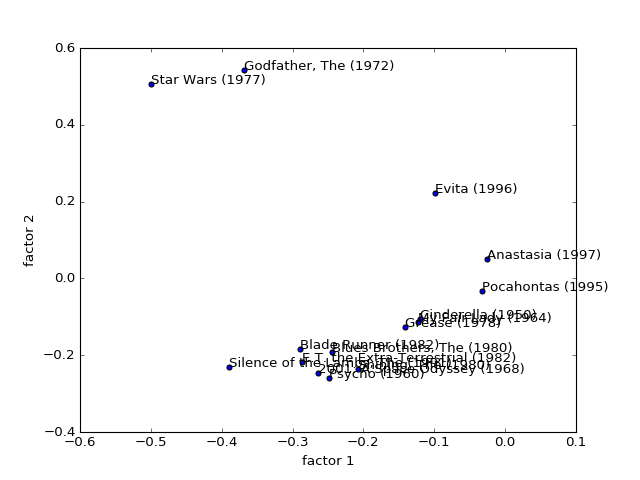

In [84]:
# Recall that Vt is holding the movie-related factors
plt.figure()
plt.scatter(Vt[factor_x_index,:], Vt[factor_y_index,:])
for movie_index in range(len(movies_considered)):
    plt.annotate(
        movie_data[index_to_movie[movie_index]],
        (Vt[factor_x_index, movie_index], Vt[factor_y_index, movie_index]))
plt.xlabel('factor %d' % (factor_x_index + 1))
plt.ylabel('factor %d' % (factor_y_index + 1))
# optional: save higher-resolution *.png locally
# plt.savefig('name_of_plot', ext='png', dpi=150)
plt.show()

<IPython.core.display.Javascript object>


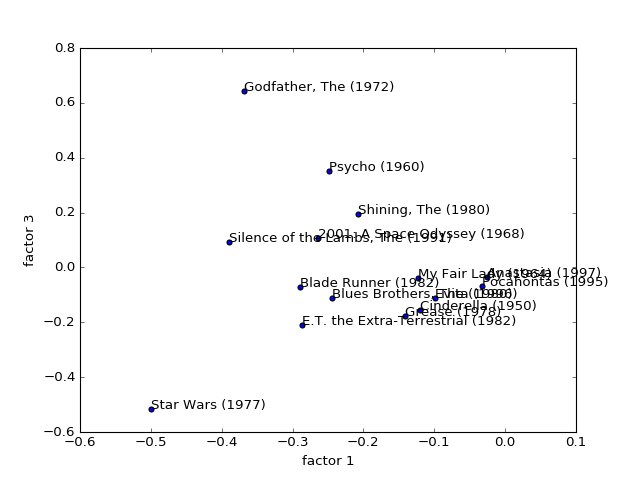

In [85]:
# Recall that Vt is holding the movie-related factors
plt.figure()
plt.scatter(Vt[factor_x_index,:], Vt[factor_z_index,:])
for movie_index in range(len(movies_considered)):
    plt.annotate(
        movie_data[index_to_movie[movie_index]],
        (Vt[factor_x_index, movie_index], Vt[factor_z_index, movie_index]))
plt.xlabel('factor %d' % (factor_x_index + 1))
plt.ylabel('factor %d' % (factor_z_index + 1))
# optional: save higher-resolution *.png locally
# plt.savefig('name_of_plot', ext='png', dpi=150)
plt.show()

<IPython.core.display.Javascript object>


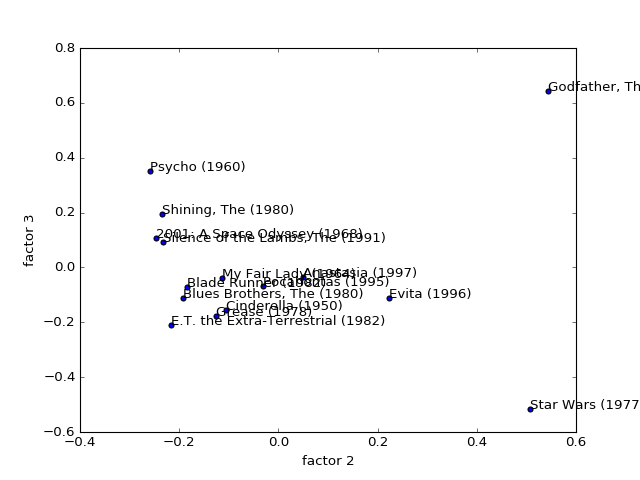

In [86]:
# Recall that Vt is holding the movie-related factors
plt.figure()
plt.scatter(Vt[factor_y_index,:], Vt[factor_z_index,:])
for movie_index in range(len(movies_considered)):
    plt.annotate(
        movie_data[index_to_movie[movie_index]],
        (Vt[factor_y_index, movie_index], Vt[factor_z_index, movie_index]))
plt.xlabel('factor %d' % (factor_y_index + 1))
plt.ylabel('factor %d' % (factor_z_index + 1))
# optional: save higher-resolution *.png locally
# plt.savefig('name_of_plot', ext='png', dpi=150)
plt.show()

## Rating prediction using matrix factorization
We can use matrix factorization to predict user ratings.

Looking at our 10 users, let's remove one from the user-item matrix, and try to predict the ratings for this user.

Say we remove the fourth user from <code>users_considered</code>:

In [87]:
user_to_predict = users_considered[3]
ratings_to_predict = R[3,:]
print 'to predict: %s for user %s.' % (ratings_to_predict, user_to_predict)

to predict: [ 4.  5.  3.  0.  4.  3.  5.  2.  0.  3.  4.  1.  0.  0.  0.] for user 5.


We remove this user from R and re-establish the factorization on the new matrix.

In [88]:
# remove the user from users_considered
users_considered.remove(users_considered[3])
# redo the lookup indices
user_to_index = dict(zip(users_considered, range(len(users_considered))))
index_to_user = dict(zip(user_to_index.values(), user_to_index.keys()))      

# remove user from R
R = np.delete(R, (3), axis=0)
R

array([[ 5.,  5.,  4., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 4.,  4.,  4., ...,  0.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  5., ...,  5.,  0.,  0.]])

In [89]:
# redo the SVD
U, S, Vt = scipy.linalg.svd(R, full_matrices=False)

<IPython.core.display.Javascript object>


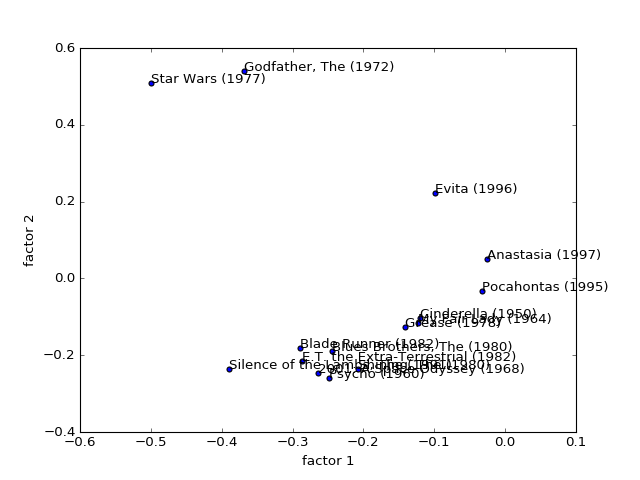

In [90]:
# make a new scatter plot
plt.figure()
plt.scatter(Vt[factor_x_index,:], Vt[factor_y_index,:])
for movie_index in range(len(movies_considered)):
    plt.annotate(
        movie_data[index_to_movie[movie_index]],
        (Vt[factor_x_index, movie_index], Vt[factor_y_index, movie_index]))
plt.xlabel('factor %d' % (factor_x_index + 1))
plt.ylabel('factor %d' % (factor_y_index + 1))
plt.show()

Note how this plot differs from your previous scatter plot.

The SVD solving approach suffers from sign indeterminacy, which means that the sign corresponding to a factor may flip for different initializations. Still, internal relationships should reasonably hold, and that indeed is the case (e.g. on factor 2, Psycho and Evita are still strong opposites).

## Performing rating prediction
Say we will only consider the first two factors, and try to predict the ratings using this model for our user 222.

We will first project the user's rating into 2D factor space by multiplying with $\mathbf{V}$:

In [91]:
ratings_to_predict_2d = np.dot(ratings_to_predict, Vt[0:2,:].transpose())

Then, reconstruct the data by multiplying with  $\mathbf{V^T}$:

In [92]:
ratings_to_predict_reconstructed = np.dot(ratings_to_predict_2d, Vt[0:2,:])
print ratings_to_predict_reconstructed
print ratings_to_predict

[ 2.78063058  3.54582961  4.74544588  1.38149407  3.56787855  3.47344041
  3.14037968  2.97664544  0.05751956  1.59002951  3.66243864  1.88570751
  1.66882029  0.04230049  0.45103894]
[ 4.  5.  3.  0.  4.  3.  5.  2.  0.  3.  4.  1.  0.  0.  0.]


To get a better feel for how accurate the prediction is, implement the RMSE measure:

In [93]:
def RMSE(array1, array2):
    # Replace -1 by a proper RMSE (Root Mean Square Error) implementation.
    # You will at least need np.sqrt() -- consult the numpy documentation and use the IPython tab completion to further
    # establish the necessary functionality.
#     print type(array1-array2)
    return np.sqrt(sum(np.square(array1-array2))/len(array1))

# what is the RMSE for our example?
RMSE(ratings_to_predict, ratings_to_predict_reconstructed)

1.1331200793031591

## I don't see how this SVD reconstruction works?
If you need to read up on your SVD background, check http://infolab.stanford.edu/~ullman/mmds/ch11.pdf and the corresponding examples.

## Wrapping up this lab assignment
We now gave you examples of how to perform matrix factorization on a movie ratings dataset.

For your lab course deliverable of this week, please play around with these examples more, and examine at least the effect of using different sizes of user populations.

* Our current example only used 10 (or 9) users, what would happen if you use slightly more, or many more? How are the main latent factors affected, how is RMSE affected?

* In the scatter plot, play around with different factors. Instead of the first two, you can for example also test the first and the third.

* Optional: What would happen to the factorization if you would include other movies? Some nice ones to try are:
<code>
movieID 127: 'Godfather, The (1972)'
movieID 423: 'E.T. the Extra-Terrestrial (1982)'
movieID 485: 'My Fair Lady (1964)'
</code>
but feel free to consult <code>u.item</code> to select the IDs and titles of movies you find interesting.

As indicated above, hand in a \*.pdf report named<code>[studentNumberMember1_studentNumberMember2.pdf]</code> in which you include **three** latent factor scatter plots, obtained for **three different input data slices**, which at least differ in terms of user population size (so the size of <code>users_considered</code>.

For each of the scatter plots, do two things:
  * specify the characteristics of your input data (e.g. population size, selection criteria for users and films);
  * based on each plot, give a possible interpretation of what the factors represented by the x and y axes of your plot may indicate.

You can simply retrieve the scatter plot images for your report by using the 'download' button underneath each plot.

Alternatively, you can export higher-resolution images through <code>savefig</code>, e.g.

<code>$ plt.savefig('name_of_plot', ext='png', dpi=150)</code>.

Place this call before calling <code>plt.show()</code>; also see the commented line accompanying the first scatter plot.
